### Solution_Space_per_Num_of_Baseline-graph_widths

Objective is to analyze how the solution space relates to the number of baselines and to spacing of antenas. We also consider the solution path by implementing LMA for the two starting model parameters.  

Plotted are:  
1. Solution space for different baseline profiles.  
2. Solution path for the further model parameters onto the solution space to test how LMA performs as baselines are increased.  
3. Graph of the measured widths of the global valley where the true solution lies.   


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ssig
import random
import ProjectPacks as pp
import ProjectFuncs as pf

%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)  #spreads out plot surface for better visualization

from IPython.display import HTML 
HTML('../style/course.css') #apply general CSS

from IPython.display import HTML
HTML('../style/code_toggle.html')

In [2]:
## temporary file we write different array configurations out to. 
fout='temp_arr.txt'
 
def create_arrayfile(arr=[70,80,100,130,170,220,300],freq=1.4e9):
    with open(fout,'w') as f:
        f.write("{} {} \n".format("Num_Array: ",len(arr)))
        atxt=''
        for i,a in enumerate(arr): 
            atxt=atxt+' '+str(a)
            if i<len(arr)-1: atxt=atxt+','
        print(atxt)
        f.write("{} {} \n".format("Centre_Dist: ",atxt ) )
        f.write("{} {} \n".format("Centre_Freq: ",freq))


In [3]:
def get_res(u_mat,v_mat,d): #only making A constant to save time

    rr_constA= np.empty((timeslots,timeslots))

    for a in range(timeslots):
        for b in range(timeslots):

            x_r= np.array([[L[a],M[b],x_true[0,2]]])
            rr_constA[a,b]= np.square(np.linalg.norm(pf.modfunc_res(x_r,u_mat,v_mat,d)))/(int(len(u_mat)*(len(u_mat)-1)/2))

    Minimum_A= np.unravel_index(np.argmin(rr_constA),rr_constA.shape)
    print("Minimum value of (L,M) is at {} and is: ".format(Minimum_A),rr_constA[Minimum_A])

    return rr_constA, Minimum_A


def find_nearest(array): 
    
    loc_maxs= ssig.argrelmax(array)
    glob_min= np.argmin(array)
    
    id1 = (np.abs(loc_maxs[0]-glob_min)).argmin()
    id2 = ((loc_maxs[0]-glob_min)>0).argmax()
        
    return loc_maxs[0][id1],loc_maxs[0][id2]
    
# %prun get_res()

In [4]:
## trying out real case first
def levenberg_marquardt(data, u_ant, v_ant, x, r_func, j_func, maxit=100, lamda=1, K=10, eps1=1e-6, eps2=1e-6):
    """
    Returns a vector containing the optimal parameter values found by the algorithm.
    
    INPUTS:
    data      Vector of measured values.
    x         Vector of parameters. (S,3)
    r_func    Function which generates the residual vector. (1,t*nb)
    j_func    Function which generates the (Conjugate of) Jacobian & the Hessian. (S*3,t*nb) & (S*3,S*3) 
    maxit     Maximum number of iterations.
    lamda     Initial value of tuning parameter.
    K         Initial value of retuning factor.
    eps1      First tolerance parameter - triggers when residual is below this number.
    eps2      Second tolerance parameter - triggers when relative changes to the parameter
              vector are below this number.
    """
    
    #Initialises some important values and stores the original lamda value.
    r = r_func(x, u_ant, v_ant, data)
    #print("Shape of residual vec: ", np.shape(r))
    
    old_chi = np.linalg.norm(r)
    olamda = lamda
    it = 0

    chiplot=[]
    chiplot.append(old_chi)
    
    solpath= x
    
    while True:
        solpath= np.vstack((solpath,x))  
        #Heavy lifting portion of the algorithm. Computes the parameter update.
        #This is just the implementation of the mathmatical update rule.
        JH,JHJ = j_func(x,u_ant,v_ant)
        
        JHJdiag = np.diag(np.diag(JHJ))
        #this says there is a different D for each timeslot
        #lamda = 1 if (it%2==0) else 0
        JHJinv= np.linalg.pinv(JHJ+lamda*JHJdiag)
        JHr = JH.dot(r)
        
        delta_x = JHJinv.dot(JHr)        
        x += delta_x.real.reshape((len(x),3))
        
        #solpath= np.vstack((solpath,x))  
        
        #Convergence tests. If a solution has been found, returns the result.
        #The chi value is the norm of the residual and is used to determine
        #whether the solution is improving. If the chi value is sufficiently 
        #small, the function terminates. The second test checks to see whether
        #or not the solution is improving, and terminates if it isn't.
        
        r = r_func(x, u_ant, v_ant, data)
        new_chi = np.linalg.norm(r)
        chiplot.append(new_chi)
        
        if new_chi < eps1:
            return x,chiplot,solpath
        elif np.linalg.norm(delta_x.real) < eps2*(np.linalg.norm(x) + eps2):
            return x,chiplot,solpath
        
        #Tuning stage. If the parameter update was good, continue and restore lamda.
        #If the update was bad, scale lamda by K and revert last update.
        
        if new_chi > old_chi:
            x -= delta_x.real.reshape((len(x),3))
            lamda = lamda*K
        else:
            old_chi = new_chi
            lamda = olamda
            
        #If the number of iterations grows too large, return the last value of x.
        
        it += 1
            
        if it >= maxit:
            return x,chiplot,solpath


In [5]:
#import profile
timeslots= 300
t = np.arange(0, 5, 5/timeslots)          #The points at which we will be taking our "measurements"

x_true = np.radians([[0.34,0.45,4.]])          #The true (starting) values of our parameter vector (for alg).

L= np.radians(np.arange(-1,1,2/timeslots))
M= np.radians(np.arange(-1,1,2/timeslots))
A= np.radians(np.arange(1,11,10/timeslots))

In [6]:
#from ipywidgets import interact

## shows what happens when both number of ants increases and baseline length increases

def solpath_per_NumAndLen(Max_Num_of_Ants,x_mod,configs_func= lambda x: 3*(np.square(x)+4)):
    
    x_= np.arange(1,Max_Num_of_Ants+1)
    array_dist_configs= configs_func(x_)
    
    create_arrayfile(arr= array_dist_configs)
    A_mod,l_mod,m_mod,ut,vt,arrayHxpos= pp.formatSParams(fout,'Field_Profile.txt',td=timeslots)
    
    L_widths= []
    for i in range(3,Max_Num_of_Ants+1,4):
    
        u_t= ut[:i,:i]
        v_t= vt[:i,:i]

        nbl= int(len(u_t)*(len(u_t)-1)/2)
        noise = 0.000*np.random.normal(size=(timeslots*2*nbl)) 
        
        d= pf.modfunc(x_true,u_t,v_t)
        x_start= x_mod.copy()
        
        solved_x,cplot,spath = levenberg_marquardt(d,u_t,v_t,x_mod,pf.modfunc_res,pf.modfunc_jac)

        RR_const= get_res(u_t,v_t,d)
        Lmin_slice = RR_const[0][:,RR_const[1][1]]
        
        near_maxs= find_nearest(Lmin_slice) #returns index of local maxima nearest global minimum
        nm_range = near_maxs[1]-near_maxs[0]
        
        print("Local peaks nearest to the global minimum are at positions: \n",near_maxs)

        plt.subplot(221)
        plt.imshow(np.flipud(RR_const[0]), extent=[-1,1,-1,1])
        plt.plot(x_true[0,1]*180/np.pi,x_true[0,0]*180/np.pi,'ro',spath[1:,1]*180/np.pi,spath[1:,0]*180/np.pi,'k',lw=1) #changed x_true[0] to x_true[0,0]
        plt.plot(solved_x[0,1]*180/np.pi, solved_x[0,0]*180/np.pi, 'kx',lw=1)
        plt.colorbar()
        plt.grid()
        plt.xlabel("m_values in degrees")
        plt.ylabel("l_values in degrees")
        plt.title("Contour mapping of L,M, \n constant A with {} ants".format(i))
        plt.legend(["Global minimum","Solution path"],loc="lower right")
        
#         plt.subplot(222)
#         plt.plot(cplot,'g',linewidth= 3.0)
#         plt.xlabel("Iteration")
#         plt.ylabel(r'$\chi^2$'+" -error")
#         plt.title("Chi-squared error curve per iteration \n of LMA for {} antennas".format(i))
#         plt.show()
                            
        plt.subplot(222)
        plt.plot(L*180/np.pi,Lmin_slice, 'b', x_true[0,0]*180/np.pi,[0],'ro') #changed x_true[0] to x_true[0,0]
        
        plt.plot(L[near_maxs[0]]*180/np.pi,Lmin_slice[near_maxs[0]],"g^") #left nearest (to global min) local max
        plt.plot(L[near_maxs[1]]*180/np.pi,Lmin_slice[near_maxs[1]],"g^") #right nearest local max
        
        # illustration of width of global valley
        plt.plot(L[near_maxs[0]:near_maxs[1]+1]*180/np.pi,np.max(Lmin_slice)*np.ones(nm_range+1), "k")
        
        plt.title("Slice along L against true M for \n {} ants - normalized over #(baselines)".format(i))
        plt.grid("on")
        plt.xlabel("m = 0.45 and l in [-1,1] (in degrees)")
        plt.ylabel("Residual norm")
        
        plt.show()
        
        L_widths.append(L[near_maxs[1]]-L[near_maxs[0]]) #in radians
        
    return L_widths #in radians


 15, 24, 39, 60, 87, 120, 159, 204, 255, 312, 375, 444, 519, 600, 687
Minimum value of (L,M) is at (201, 217) and is:  0.0010308531834
Local peaks nearest to the global minimum are at positions: 
 (136, 266)


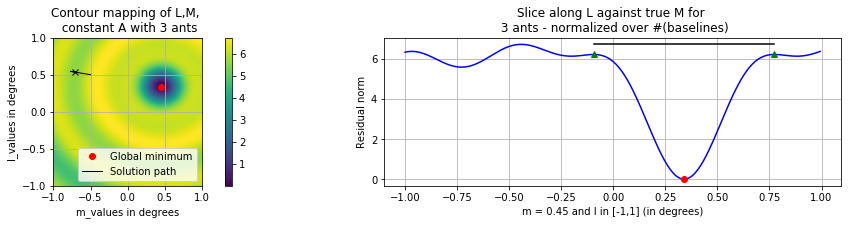

Minimum value of (L,M) is at (201, 217) and is:  0.0196994833673
Local peaks nearest to the global minimum are at positions: 
 (166, 236)


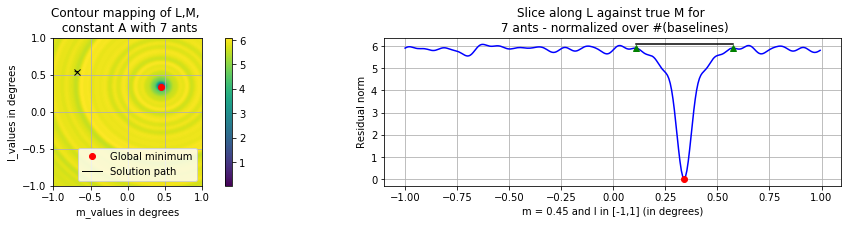

Minimum value of (L,M) is at (201, 217) and is:  0.10431255749
Local peaks nearest to the global minimum are at positions: 
 (177, 225)


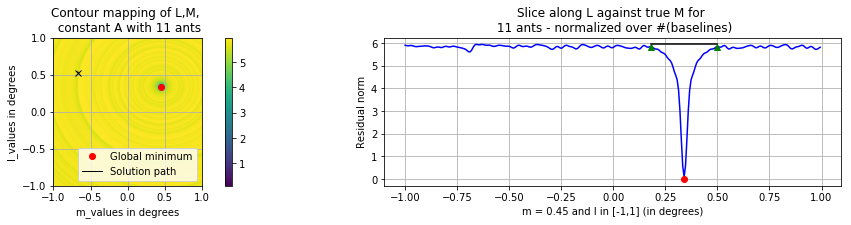

Minimum value of (L,M) is at (201, 217) and is:  0.330174351458
Local peaks nearest to the global minimum are at positions: 
 (183, 219)


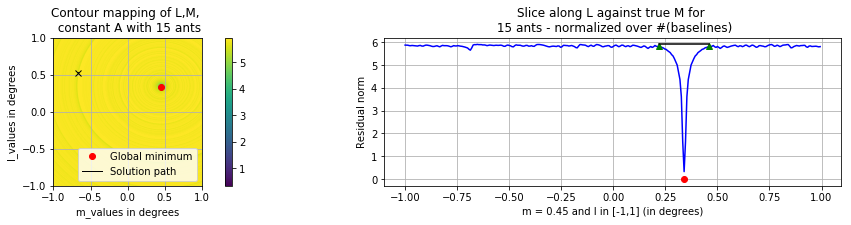

In [7]:
Ants_maxnum=15

valley_widths = solpath_per_NumAndLen(Ants_maxnum,np.radians([[0.5,-0.5,5.]]))

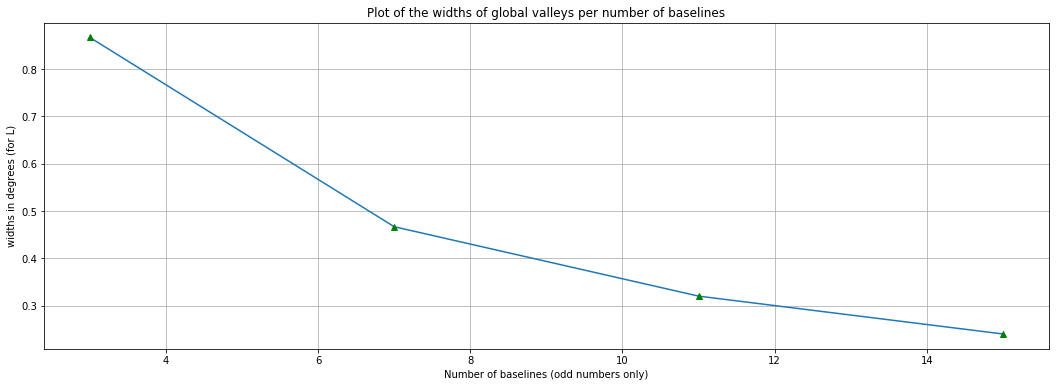

In [9]:
plt.plot(np.arange(3,Ants_maxnum+1,4),np.array(valley_widths)*180/np.pi)
plt.plot(np.arange(3,Ants_maxnum+1,4),np.array(valley_widths)*180/np.pi,"g^")
plt.title("Plot of the widths of global valleys per number of baselines")
plt.xlabel("Number of baselines (odd numbers only)")
plt.ylabel("widths in degrees (for L)")
plt.grid("on")
plt.show()